# Geneticos en Python: DEAP

### Instalación

https://anaconda.org/conda-forge/deap

### Ejemplo comentado

#### Tipos

En DEAP en lugar de proporcionar tipos predefinidos se proporciona una manera de generar nuestros propios tipos.

El módulo **creator** permite crear nuestros problemas.

```Python
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", numpy.ndarray, fitness=creator.FitnessMax)
```

Crea *FitnessMax* como un tipo de problema de maximización.

Segun el valor de weights, el problema puede ser:
- (1.0,) maximizar
- (-1.0,) minimzar
- (-1.0, 1.0) Multi (minimizar el primero y maximizar el segundo)

Se esta creando un individuo, que está representado por un array de numpy y pertenece al problema de maximización.






#### Inicialización

Una vez que se crean los tipos hay que asignarles valores.

El paquete **toolbox** contiene herramientas para hacer esto.

```Python
IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
```

Este código crea *attribute* que es un float con valor random. Los individuos  (*individual*) son una lista de *attribute* de tamaño *IND_SIZE* y *population* es una lista de individuos.

Con **toolbox.population()** crearía automáticamente una población y con **toolbox.individual()** un individuo.



#### Operadores 

Los operadores de evaluación, selección, mutación y cruce son funciones. El usuario puede implementarlas o usar las que se encuentran en el módulo **tools**

```Python
def evaluate(individual):
    return sum(individual),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
```

##### Evaluación
La función de evaluación debe devolver una tupla ya que la optimización mono-objetivo es un caso especial de la multi-objetivo.
La función **evaluate** devuelve la tupla con la suma y None, pero devuelve una tupla.

##### Mutación

Las funciones de mutación solo mutan, si se quiere mantener el original hay que hacer una copia explicitamente y almacenarla.

```Python
mutant = toolbox.clone(ind1)
ind2, = tools.mutGaussian(mutant, mu=0.0, sigma=0.2, indpb=0.2)
del mutant.fitness.values
```

(Se borran los valores de fitness porque no pertenecen al individuo mutado, sino al individuo anterior)

- mutGaussian() Aplica una mutación de media mu y desviación sigma. Espera valores float
- mutFlipBit() Invierte valores con una determinada probabilidad, espera booleanos.

##### Cruce 

Hay variedad de operadores, cada uno espera un determinado tipo de individuos.
Las funciones de cruce solo cruzan, si se quiere mantener el original hay que hacer una copia explicitamente y almacenarla.

```Python
child1, child2 = [toolbox.clone(ind) for ind in (ind1, ind2)]
tools.cxBlend(child1, child2, 0.5)
del child1.fitness.values
del child2.fitness.values
```

- cxBlend() Espera floats, recibe un alpha que regula que valores se cogen de cada individuo
- cxOnePoint() Hasta un punto aleatorio es de un individuo y despues del otro.
- cxTwoPoint()

#### Selección

Son funciones que reciben un contenedor de individuos y el número de individuos a seleccionar.
Si un individuo se selecciona dos veces, no se copia, los dos individuos apuntan al mismo objeto. Y mutar el uno muta al otro también. Habría que clonarlos.

```Python
selected = toolbox.select(population, LAMBDA)
offspring = [toolbox.clone(ind) for ind in selected]
```

- selTournament()
- selBest()

### Usando Toolbox

El **Toolbox** tiene dos métodos **register()** y **unregister()** que ponen y quitan herramientas del toolbox.

En el toolbox se registran las operaciones de cruce, mutación, selección y evaluación.

### Algorithms

Hay varias implementaciones de algoritmos evolutivos en el módulo **algorithms**, estos algoritmos usan los métodos registrados en el **Toolbox**

- eaSimple El algoritmo genético simple de “Evolutionary Computation 1 : Basic Algorithms and Operators” capitulo 7

### Ejemplo de la documentación

In [1]:
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = np.array((1,2,3,4))
        >>> b = np.array((5.6.7.8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2
    
    
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(64)
    
    pop = toolbox.population(n=300)
    
    ''' aqui meteria la red inicial
    guess_ind = creator.Individual(valores)
    
    pop.pop()
    pop.insert(0, guess_ind) 
    '''
    
    # Numpy equality function (operators.eq) between two arrays returns the
    # equality element wise, which raises an exception in the if similar()
    # check of the hall of fame. Using a different equality function like
    # numpy.array_equal or numpy.allclose solve this issue.
    hof = tools.HallOfFame(1, similar=np.array_equal)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, stats=stats,
                        halloffame=hof)

    return pop, stats, hof

if __name__ == "__main__":
    main()

gen	nevals	avg    	std    	min	max
0  	300   	50.4933	5.33822	34 	64 
1  	181   	54.8333	4.34958	44 	66 
2  	191   	58.4567	3.45564	47 	68 
3  	199   	60.9533	2.9025 	52 	68 
4  	167   	62.96  	2.90719	47 	71 
5  	175   	64.99  	2.84896	57 	73 
6  	168   	66.9333	2.80515	58 	74 
7  	187   	68.9167	2.82661	59 	76 
8  	171   	70.8867	2.4455 	62 	76 
9  	155   	72.69  	2.62435	62 	80 
10 	171   	74.1233	2.61052	64 	82 
11 	191   	75.64  	2.70007	65 	82 
12 	171   	77.18  	2.55752	69 	84 
13 	173   	78.7667	2.24475	69 	84 
14 	185   	79.9067	2.36459	72 	86 
15 	205   	81.4433	2.3805 	72 	88 
16 	163   	82.6767	2.22534	74 	88 
17 	175   	83.6833	2.37411	76 	88 
18 	181   	84.8067	2.30274	74 	90 
19 	179   	85.6233	2.51955	74 	91 
20 	178   	86.58  	2.16416	78 	91 
21 	173   	87.2533	2.33148	78 	91 
22 	155   	88.06  	2.15787	79 	92 
23 	187   	88.37  	2.20146	80 	92 
24 	184   	89.2767	1.97825	82 	94 
25 	198   	89.7767	2.3805 	80 	95 
26 	185   	90.6233	2.41553	80 	96 
27 	160   	91.62  	2

# Ejemplo propio

Encontrar $x, y ,z$ que minimizan una función

$f(x,y,z) = (x-2)^2 + (y-3)^2 + (z-5)^2$

Los óptimos serían $x=2, y=3, z=5$

In [2]:
'''
En la función de evaluación, se devuelve un tupla aunque solo se optimize un valor, por eso
la coma despues del primer valor retornado
'''
def evalFunct(individual):
    x,y,z = individual
    return (x-2)**2 + (y-3)**2 + (z-5)**2,

arr = np.array([2,3,5])
evalFunct(arr)


creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Minimiza
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# se registra attr_int como un entero aleatorio entre 0 y 10
# se registra individual como una repetición de attr_int de tamaño 3, el contenedor es el tipo Individual
# se registra population como una repetición de individual, el contenedor es una lista
toolbox.register("attr_int", random.randint, 0, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFunct)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


random.seed(64)

# se crea una población inicial de 50
pop = toolbox.population(n=50)    
    
'''
HallOfFame contiene los N mejores individuos vistos durante todo el proceso
Como el tipo del individuo es personalizado hay que pasarle una función de comparación
'''    
hof = tools.HallOfFame(1, similar=np.array_equal)
    
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
    
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof)
print(hof)  
hof[0] # esta ordenado de manera que el primer elemento es el mejor de siempre

gen	nevals	avg  	std    	min	max
0  	50    	42.84	25.1256	5  	102
1  	25    	24.58	13.8565	5  	74 
2  	36    	12.56	7.25854	2  	33 
3  	27    	7.34 	3.85544	1  	17 
4  	32    	4.22 	1.64061	1  	9  
5  	32    	2.8  	1.44222	1  	5  
6  	26    	1.82 	0.993781	1  	5  
7  	29    	1.22 	0.46    	0  	2  
8  	34    	0.98 	0.373631	0  	2  
9  	34    	0.8  	0.52915 	0  	2  
10 	34    	0.5  	0.574456	0  	2  
[Individual([2, 3, 5])]


Individual([2, 3, 5])

El mismo ejemplo pero con un *initial_guess* inicializo la población con algunos individuos que no son aleatorios
http://deap.readthedocs.io/en/master/tutorials/basic/part1.html#seeding-a-population

In [3]:
def initPopulation(pop, ind_random, ind_guess,n_guess=1,n=10):
    
    pop = []
    n_random = n - n_guess
    for i in range(n_random):
        pop.append(ind_random())
        
    for i in range(n_guess):
        pop.append(ind_guess())
    
    return pop

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 10)
toolbox.register("individual_rnd", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)
toolbox.register("individual_guess", lambda :creator.Individual(np.array([3,4,5])))
toolbox.register("population_mix",initPopulation,list,toolbox.individual_rnd, toolbox.individual_guess)       

# ejemplo para ver como se crea una población de 10, con 3 fijados por mi
print(toolbox.population_mix(n=10, n_guess=3))

toolbox.register("evaluate", evalFunct)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


random.seed(64)

# se crea una población de 50 con 10 fijos (he usado la función population_mix)
pop = toolbox.population_mix(n=50, n_guess=10)      
    
'''
HallOfFame contiene los N mejores individuos vistos durante todo el proceso
Como el tipo del individuo es personalizado hay que pasarle una función de comparación
'''    
hof = tools.HallOfFame(1, similar=np.array_equal)
    
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
    
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof)
print(hof)  # ahora en lugar de converger en la generación 7, lo hace en la generación 4
hof[0] 


[Individual([10,  3,  9]), Individual([8, 8, 7]), Individual([2, 3, 5]), Individual([5, 2, 4]), Individual([1, 1, 5]), Individual([3, 6, 0]), Individual([0, 1, 3]), Individual([3, 4, 5]), Individual([3, 4, 5]), Individual([3, 4, 5])]
gen	nevals	avg  	std    	min	max
0  	50    	35.32	28.1946	2  	102
1  	30    	10.98	10.6066	1  	36 
2  	33    	4.56 	5.74164	1  	26 
3  	26    	1.76 	0.471593	1  	3  
4  	35    	1.4  	0.565685	0  	2  
5  	29    	1.02 	0.50951 	0  	2  
6  	28    	0.8  	0.447214	0  	2  
7  	31    	0.52 	0.538145	0  	2  
8  	29    	0.16 	0.417612	0  	2  
9  	29    	0.04 	0.195959	0  	1  
10 	27    	0.06 	0.237487	0  	1  
[Individual([2, 3, 5])]


Individual([2, 3, 5])

# Redes neuronales con Sklearn

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

El MLPClassifier tiene varios solvers:
- adam, un tipo de stochastic gradient descent para datos grandes
- lbfgs para pequeños converge antes.

solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’


Funciona para multilabel, pero no para multioutput, habría que modificar las clases

In [5]:
train = [[0., 0.], [1., 1.]]
labels = [[0, 1], [1, 1]]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)

clf.fit(train, labels)                

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

**coefs\_** es una lista de matrices donde la matriz *i* representa los pesos entre la capa *i* y la capa *i+1*

**intercepts\_** es un lista de vectores bias donde el vector *i* representa los bias añadidos a la capa *i+1*

Nota: Por defecto 3 capas, entrada, capa oculta y capa de salida. Los coeficientes son de la entrada a la intermedia y de la intermedia a la salida. Los bias son de la intermedia y la de salida.

In [6]:
[coef.shape for coef in clf.coefs_]

[(2, 15), (15, 2)]

# Pipelines

Uno de los consejos que se mencionan en la documentación de sklearn para el uso de las redes neuronales es la estandarización de los datos.
http://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use

Los perceptrones multicapa son sensibles a la escala de los datos y por lo tanto es recomendable *escalar* los datos. Para cada atributo es recomendable que sus valores se encuentren entre [0, 1] o [-1, +1] o estandardizar que significa que tengan media 0 y varianza 1 

Se podría estandardizar haciendo lo siguiente:



In [7]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler  


X_train, y = make_blobs(n_samples=10, centers=4,
                  random_state=0, cluster_std=1.0)

print(X_train," media ",np.mean(X_train,axis=0)," std ",np.std(X_train,axis=0))
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
print(X_train," media ",np.mean(X_train,axis=0)," std ",np.std(X_train,axis=0))

# apply same transformation to test data

#X_test = scaler.transform(X_test) 

[[ 0.87305123  4.71438583]
 [ 2.36833522  0.04356792]
 [ 2.49913075  1.23133799]
 [ 1.7373078   4.42546234]
 [-1.20249726  7.64827617]
 [-0.66246781  2.17571724]
 [ 1.12031365  5.75806083]
 [ 3.54934659  0.6925054 ]
 [ 1.02149885  6.38109434]
 [-4.07989383  3.57150086]]  media  [ 0.72241252  3.66419089]  std  [ 2.09387548  2.43729314]
[[ 0.07194253  0.43088577]
 [ 0.78606523 -1.48550985]
 [ 0.84853099 -0.99817821]
 [ 0.48469706  0.312343  ]
 [-0.9193048   1.63463524]
 [-0.66139574 -0.61070768]
 [ 0.19003094  0.85909647]
 [ 1.35009655 -1.21925649]
 [ 0.14283864  1.11472166]
 [-2.2935014  -0.03802991]]  media  [ -8.88178420e-17   1.17961196e-17]  std  [ 1.  1.]


La forma recomendada de hacer la estandarización es usando **Pipelines**.

Los pipelines se pueden usar para encadenar multiples estimadores en uno solo. Son útiles para aplicar una secuencia fija de pasos para procesar los datos. Los pipelines tienen dos propositos:
- Simplicidad: Solo hay que llamar a fit o predict una vez y se aplica la secuencia completa de estimadores.
- Selección de parámetros conjunta: Con grid search u otro método se podrian buscar todos los parámetros de todos los estimadores a la vez.

Todos los estimadores, menos el último deben de ser *transformers* (selectores de atributos, normalización, PCA ...)

Un Pipeline se construye usando una lista de (clave, valor) donde la clave contiene el nombre de los que se quiere aplicar y el valor es el objeto del estimador.


The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object:

```Python
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 
```

La función **make_pipeline** es una abreviatura para crear pipelines sin tener que dar nombres

The utility function make_pipeline is a shorthand for constructing pipelines; it takes a variable number of estimators and returns a pipeline, filling in the names automatically:

```Python
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB()) 
```

Los estimadores están almacenados como una lista en el atributo **steps** o como un diccionario en el atributo **named_steps** (Esto es importante)

Los parámetros del estimador pueden ser accedidos usando la sintaxis <estimator>__<parameter>
ejemplo:

```Python
pipe.set_params(clf__C=10) 
```


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


estimators = [('stantandarize', StandardScaler()), ('clf', MLPClassifier())]

pipe = Pipeline(estimators)

# entreno el pipe como si fuera un clasificador, 
# también podría hacer validación cruzada y todo como si fuese un clasificador normal
pipe.fit(train, labels)

[coef.shape for coef in pipe.named_steps['clf'].coefs_]

C:\Users\Pablo Alejos\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[(2, 100), (100, 2)]

Creo una función para visualizar la frontera de decisión de un MLP

In [9]:
def visualize_trained_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    
    # model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Creo una nube de puntos con cuatro clases. Voy a usar estos datos para entrenar un MLP, luego voy a cambiar un poco estos datos y voy a evolucionar los pesos de la red para que se adapten a ese cambio

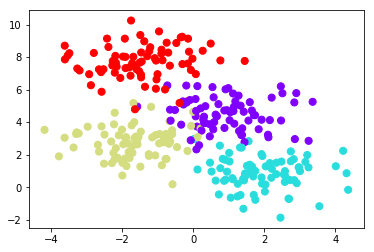

In [10]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [11]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)


pipe = Pipeline([('stantandarize', StandardScaler()), ('clf', clf)])
pipe.fit(X, y)

  

# model es una copia del pipe que voy a usar en la función de fitness
# voy a acceder a la red a traves de su nombre (ver la función MLPFitness)
from copy import deepcopy
model = deepcopy(pipe)

Voy a modificar los pesos obtenidos por backpropagation para que acaben ajustando a Xprima en lugar de a X.

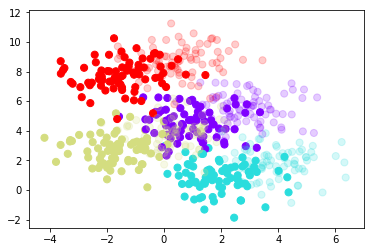

In [12]:
Xprima=X+[2,1]
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');
plt.scatter(Xprima[:, 0], Xprima[:, 1], c=y, s=50, cmap='rainbow',alpha=0.2);

A continuación las fronteras de decisión con los datos originales y con los datos ligeramente modificados.

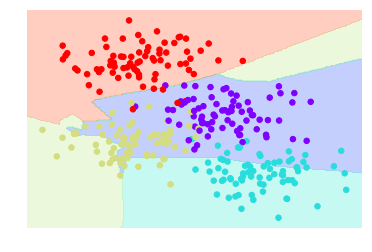

In [13]:
visualize_trained_classifier(pipe, Xprima, y)

In [14]:
# accediendo a los pesos de la red a traves de su nombre
# model es un pipeline
# model.named_steps['clf'] es la red neuronal

shapes = [coef.shape for coef in model.named_steps['clf'].coefs_] 
sizes =[coef.size for coef in model.named_steps['clf'].coefs_]

In [15]:
shapes,sizes

([(2, 15), (15, 4)], [30, 60])

Antes de nada necesito una función para pasar de gen a pesos y otra para pasar de pesos a gen, lógicamente estas funciones necesitan conocer los tamaños y formas de los pesos de la red.

In [16]:
def gen2Coefs(gen,sizes,shapes):
    coefs = []
    splits = np.split(gen, [sizes[0]])
    for i in range(len(splits)):
        coefs.append(splits[i].reshape(shapes[i]))
    return coefs

def coefs2gen(coefs,sizes,shapes):
    return np.concatenate((coefs[0].flatten(),coefs[1].flatten()))

'''
# Test para probar las funciones anteriores

gen = np.arange(sum(sizes))
coefs=gen2Coefs(gen,sizes,shapes)
print(coefs[0])
print(coefs[1])
coefs2gen(coefs,sizes,shapes)
'''

'\n# Test para probar las funciones anteriores\n\ngen = np.arange(sum(sizes))\ncoefs=gen2Coefs(gen,sizes,shapes)\nprint(coefs[0])\nprint(coefs[1])\ncoefs2gen(coefs,sizes,shapes)\n'

La función de fitness será el acierto de la red con los pesos del gen, usada para clasificar el conjunto de datos modificado.

In [17]:
from sklearn.metrics import accuracy_score

def MLPFitness(individual):
    coefs=gen2Coefs(individual,sizes,shapes)
    model.named_steps['clf'].coefs_ = coefs  # aqui hay otro cambio
    preds = model.predict(Xprima)
    acc = accuracy_score(y, preds)
    return acc,

# Fitness del gen de la red original sobre los datos modificados
MLPFitness(coefs2gen(clf.coefs_,sizes,shapes))
    

(0.71333333333333337,)

Voy a tener una variable que representa el número de veces que voy a meter a la red original en la población inicial.

Con N = 0, no meto la red original y todas las redes son aleatorias, ajustando los pesos a los nuevos datos solamente con el genético. Con N=0 llega a un fitness de 0.72

Con N = 1, está la red original una vez. Con N=1 llega a un fitness de 0.9

Con N = 5, está la red original 5 veces y por lo tanto hay menos individuos aleatorios (llega a 0.92)

In [18]:
N = 5

pesosIniciales = coefs2gen(pipe.named_steps['clf'].coefs_,sizes,shapes).copy()


creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximiza
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=sum(sizes))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("individual_guess", lambda :creator.Individual(pesosIniciales))
toolbox.register("population_mix",initPopulation,list,toolbox.individual, toolbox.individual_guess)       


toolbox.register("evaluate", MLPFitness)
toolbox.register("mate", tools.cxOnePoint)

toolbox.register("mutate", tools.mutGaussian, mu=0.5, sigma=0.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=10)

random.seed(64)
# con 50 ya va    
population = toolbox.population_mix(n=50, n_guess=N)  

    
hof = tools.HallOfFame(1, similar=np.array_equal)
    
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
    
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof)
#print(hof) # hall of the fame contiene el mejor individuo vivo en cada generacion
mejorInd = hof[0] # esta ordenado de manera que el primer elemento es el mejor de siempre

MLPFitness(mejorInd)

gen	nevals	avg   	std     	min 	max     
0  	50    	0.2782	0.157366	0.04	0.713333
1  	27    	0.554733	0.204624	0.25	0.773333
2  	30    	0.728067	0.0286363	0.633333	0.783333
3  	31    	0.761133	0.0421353	0.5     	0.8     
4  	36    	0.784667	0.0194936	0.686667	0.816667
5  	32    	0.804333	0.0338575	0.6     	0.85    
6  	35    	0.8258  	0.0219273	0.713333	0.873333
7  	30    	0.836933	0.0481749	0.6     	0.876667
8  	25    	0.8522  	0.0453853	0.666667	0.89    
9  	32    	0.856933	0.0549498	0.616667	0.893333
10 	35    	0.877267	0.031039 	0.72    	0.92    
11 	24    	0.873933	0.0503485	0.7     	0.92    
12 	26    	0.8902  	0.0345602	0.68    	0.92    
13 	24    	0.883933	0.0628037	0.58    	0.933333
14 	24    	0.903267	0.0447039	0.72    	0.933333
15 	38    	0.9062  	0.0431741	0.723333	0.933333
16 	32    	0.927133	0.0224005	0.793333	0.933333
17 	18    	0.9186  	0.0390162	0.686667	0.933333
18 	23    	0.923133	0.039516 	0.666667	0.94    
19 	25    	0.910067	0.067216 	0.58    	0.94    
20 	29    	

(0.94666666666666666,)

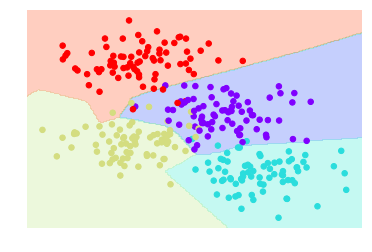

In [19]:
# frontera de decisión del mejor individuo de la población

model.coefs_= gen2Coefs(mejorInd,sizes,shapes) 
visualize_trained_classifier(model, Xprima, y)

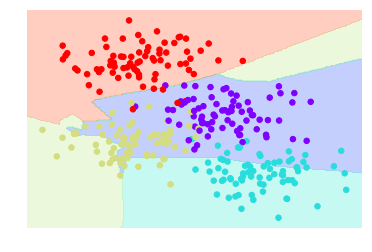

In [20]:
# frontera de decisión original
visualize_trained_classifier(pipe, Xprima, y)